Feature addition ideas:
add wine color: red, white, rose from variety add climate from region add acidity from

low cardinality: country, taster_name
high cardinality: province, region_1 and variety

3 Strategies:
1. Label encode all categorical
2. One hot encode all low cardinality columns, one hot encode high cardinals for the value_counts > 100
3. One hot encode all low cardinality, label encode high cardinality

ML Models:
1. Linear Regression
2. Support Vector Machine Regression (requires normalization)
3. K-Nearest Neighbors Regression (requires normalization)
4. Random Forest Regression
5. Extra Trees Classifier
5. Gradient Boosting Regression
6. Light GBM

recall that baseline MAE was 2.5

In [1]:
# visualization and manipulation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

# manipulation
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 60)

# text extraction
import re
import datetime

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
#to enable high resolution plots

# encoding libraries
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

# feature prepocessing and split
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, SCORERS

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb

from functions import plus_one

In [4]:
# fucntions to use iteratively
# function to train a given model, generate predictions, and return mae score
def find_production_year(title):
    int_list = []
    now = datetime.datetime.now()
    
    for item in title:
        int_list.append(int(item))
    
    for item in int_list:
        if item <= now.year and item >= 1900:
            return item
        else:
            return 0

def find_if_blend(variety):
    if (variety.find("-") != -1) | (variety.find("Blend") != -1):
        if variety == "Xarel-lo":
            return 0
        else:
            return 1
    else:
        return 0

def fit_evaluate_model(model, X_train, y_train, X_valid, Y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return mean_absolute_error(y_valid, y_predicted)

def plot_histogram(df, column):
    # set the histogram, mean and median
    g = sns.distplot(df[column], kde=False)
    plt.axvline(x=df[column].mean(),
                linewidth=3,
                color='g',
                label="mean",
                alpha=0.5)
    plt.axvline(x=df[column].median(),
                linewidth=3,
                color='y',
                label="median",
                alpha=0.5)

    # set title, legends and labels
    plt.xlabel("{}".format(column), size=14)
    plt.ylabel("Count", size=14)
    plt.title("Distribution of {}".format(column), size=16)
    plt.legend(["mean", "median"])
    
    return g



'''def value_counts_dict(df,column):
    values = df[column].value_counts()
    value_dict = values.to_dict()
    return value_dict

def assign_other(value_counts_dict):
    
    for value, counts in value_counts_dict.items():
        if counts>=100:
            value_counts_dict[value] = value
        else:
            value_counts_dict[value] = "Other"
    
    return value_counts_dict'''



'def value_counts_dict(df,column):\n    values = df[column].value_counts()\n    value_dict = values.to_dict()\n    return value_dict\n\ndef assign_other(value_counts_dict):\n    \n    for value, counts in value_counts_dict.items():\n        if counts>=100:\n            value_counts_dict[value] = value\n        else:\n            value_counts_dict[value] = "Other"\n    \n    return value_counts_dict'

In [3]:
train = pd.read_csv("train.csv")

In [4]:
train.drop(columns=["designation", "winery", "region_2"],
           inplace=True)

In [5]:
features = train.drop(columns="points")
target = train["points"]

In [6]:
features.head()

,country,description,price,province,region_1,taster_name,taster_twitter_handle,title,variety
0,US,"Expressive aromas of smoke, embers and blue fr...",35.0,Washington,Columbia Valley (WA),Sean P. Sullivan,@wawinereport,Damsel 2013 Syrah (Columbia Valley (WA)),Syrah
1,South Africa,"Soft mint, spice, cocoa and smoke on the nose ...",30.0,Stellenbosch,NaN,Susan Kostrzewa,@suskostrzewa,Simonsig 2005 Redhill Pinotage (Stellenbosch),Pinotage
2,Portugal,"An elegant, finely rounded wine, with firm tan...",NaN,Douro,NaN,Roger Voss,@vossroger,Quinta de la Rosa 2008 Red (Douro),Portuguese Red
3,South Africa,Winemaker: Louis Nel. This Cab-Shiraz blend is...,NaN,Stellenbosch,NaN,Lauren Buzzeo,@laurbuzz,Louis Nel 2015 Cape Winemakers Guild Rapscalli...,Cabernet Sauvignon-Shiraz
4,Portugal,"Lightly wood aged and spicy, this is a fine re...",NaN,Dão,NaN,Roger Voss,@vossroger,Seacampo 2014 Casa Américo Branco Reserva Encr...,Encruzado


In [7]:
target.head()

0    88
1    89
2    90
3    91
4    90
Name: points, dtype: int64

In [8]:
#features = pd.read_csv("features.csv")
#target = pd.read_csv("target.csv")

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                8994 non-null   object 
 1   description            9000 non-null   object 
 2   price                  8403 non-null   float64
 3   province               8994 non-null   object 
 4   region_1               7505 non-null   object 
 5   taster_name            7223 non-null   object 
 6   taster_twitter_handle  6888 non-null   object 
 7   title                  9000 non-null   object 
 8   variety                9000 non-null   object 
dtypes: float64(1), object(8)
memory usage: 632.9+ KB


In [10]:
target.describe()

count    9000.000000
mean       88.455222
std         3.025945
min        80.000000
25%        86.000000
50%        88.000000
75%        91.000000
max       100.000000
Name: points, dtype: float64

In [11]:
target.isna().any()

False

In [12]:
categorical_cols = list(features.select_dtypes(include="object").columns)
numeric_cols = list(features.select_dtypes(exclude="object").columns)
#low_cardinality_cols = ["country", "taster_name"]
#high_cardinality_cols = ["province", "region_1", "variety"]

In [13]:
categorical_cols

['country',
 'description',
 'province',
 'region_1',
 'taster_name',
 'taster_twitter_handle',
 'title',
 'variety']

In [14]:
numeric_cols

['price']

# Feature Engineering

1. from Description: is_red, is_white, is_rose, is_sparkling, is_dry and is_sweet
2. from Title: year
3. from Variety: is_blend
4. from taster_name and taster_twitter_handle, maybe has_twitter

## Extract Features from description

In [15]:
features["is_red"] = (features['description']
                      .str
                      .contains(r'red|RED|Red', 
                                regex = True)
                      .astype('uint8'))

In [16]:
features["is_white"] = (features['description']
                        .str
                        .contains(r'white|WHITE|White', 
                                      regex = True)
                        .astype('uint8'))

In [17]:
features["is_rose"] = (features['description']
                       .str
                       .contains(r'rose|ROSE|Rose|rosé|Rosé|ROSÉ', 
                                 regex = True)
                       .astype('uint8'))

In [18]:
features["is_sparkling"] = (features['description']
                            .str
                            .contains(r'sparkling|SPARKLING|Sparkling',
                                      regex=True)
                            .astype('uint8'))

In [19]:
features["is_dry"] = (features['description']
                      .str
                      .contains(r'dry|DRY|Dry', 
                                regex=True)
                      .astype('uint8'))

In [20]:
features["is_sweet"] = (features['description']
                        .str
                        .contains(r'sweet|SWEET|Sweet', 
                                  regex = True)
                        .astype('uint8'))

## Extract Year from title

In [21]:
features["title_numlist"] = (features
                             .title
                             .str
                             .findall(r'\b\d+\b'))

features["year"] = (features
                    .title_numlist
                    .apply(find_production_year))

## Extract is Blend from Variety

In [22]:
features["is_blend"] = (features
                        .variety
                        .apply(find_if_blend))

In [23]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                8994 non-null   object 
 1   description            9000 non-null   object 
 2   price                  8403 non-null   float64
 3   province               8994 non-null   object 
 4   region_1               7505 non-null   object 
 5   taster_name            7223 non-null   object 
 6   taster_twitter_handle  6888 non-null   object 
 7   title                  9000 non-null   object 
 8   variety                9000 non-null   object 
 9   is_red                 9000 non-null   uint8  
 10  is_white               9000 non-null   uint8  
 11  is_rose                9000 non-null   uint8  
 12  is_sparkling           9000 non-null   uint8  
 13  is_dry                 9000 non-null   uint8  
 14  is_sweet               9000 non-null   uint8  
 15  titl

In [24]:
features.head()

,country,description,price,province,region_1,taster_name,taster_twitter_handle,title,variety,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,title_numlist,year,is_blend
0,US,"Expressive aromas of smoke, embers and blue fr...",35.0,Washington,Columbia Valley (WA),Sean P. Sullivan,@wawinereport,Damsel 2013 Syrah (Columbia Valley (WA)),Syrah,0,0,0,0,0,0,[2013],2013.0,0
1,South Africa,"Soft mint, spice, cocoa and smoke on the nose ...",30.0,Stellenbosch,NaN,Susan Kostrzewa,@suskostrzewa,Simonsig 2005 Redhill Pinotage (Stellenbosch),Pinotage,1,0,0,0,0,0,[2005],2005.0,0
2,Portugal,"An elegant, finely rounded wine, with firm tan...",NaN,Douro,NaN,Roger Voss,@vossroger,Quinta de la Rosa 2008 Red (Douro),Portuguese Red,1,0,0,0,0,0,[2008],2008.0,0
3,South Africa,Winemaker: Louis Nel. This Cab-Shiraz blend is...,NaN,Stellenbosch,NaN,Lauren Buzzeo,@laurbuzz,Louis Nel 2015 Cape Winemakers Guild Rapscalli...,Cabernet Sauvignon-Shiraz,0,0,0,0,0,1,[2015],2015.0,1
4,Portugal,"Lightly wood aged and spicy, this is a fine re...",NaN,Dão,NaN,Roger Voss,@vossroger,Seacampo 2014 Casa Américo Branco Reserva Encr...,Encruzado,0,0,0,0,0,0,[2014],2014.0,0


In [26]:
a = features.loc[1,]["description"]

In [27]:
a.find("red")

148

In [28]:
a

'Soft mint, spice, cocoa and smoke on the nose lead into like flavors on the palate, creating a smooth, integrated combination of elegant and structured components that are assertive but friendly. The finish is lingering and the wine has aging potential.'

In [29]:
df4 = pd.DataFrame({'col': ['foo abc', 'foobar xyz', 'bar32', 'baz 45']})

In [30]:
terms = ['foo', 'baz']
p = r'\b(?:{})\b'.format('|'.join(map(re.escape, terms)))
df4[df4['col'].str.contains(p)]

,col
0,foo abc
3,baz 45


In [31]:
is_red_list = ["red", "Red", "RED"]
check_regex = r'\b(?:{})\b'.format('|'.join(map(re.escape, is_red_list)))
features["is_red2"] = (features['description']
                       .str
                       .contains(check_regex,
                                 regex=True)
                       .astype('uint8'))

In [42]:
features.tail()

,country,description,price,province,region_1,taster_name,taster_twitter_handle,title,variety,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,title_numlist,year,is_blend,is_red2
8995,France,"The fruit bursts out of the glass, while the s...",NaN,Burgundy,Echézeaux,Roger Voss,@vossroger,Bouchard Aîné & Fils 2005 Echézeaux,Pinot Noir,1,0,0,0,0,0,[2005],2005.0,0,1
8996,US,There's a noticeable tilt of barrel reduction ...,30.0,California,Sonoma Coast,Virginie Boone,@vboone,Krutz 2014 Magnolia Pinot Noir (Sonoma Coast),Pinot Noir,1,0,0,0,0,0,[2014],2014.0,0,0
8997,France,"This perfumed, herbal blend of Syrah and Grena...",19.0,Provence,Côtes de Provence,Roger Voss,@vossroger,Château Roquefeuille 2016 Rosé in the Air Rosé...,Rosé,0,0,1,0,1,0,[2016],2016.0,0,0
8998,Spain,Berry candy and licorice aromas become more su...,32.0,Northern Spain,Toro,Michael Schachner,@wineschach,Monte Hiniesta 2009 Toro,Tinta de Toro,0,0,0,0,0,0,[2009],2009.0,0,0
8999,Australia,"This blend of 70% Grenache, 25% Shiraz and 5% ...",65.0,South Australia,McLaren Vale,Joe Czerwinski,@JoeCz,D'Arenberg 2005 The Ironstone Pressings G-S-M ...,G-S-M,0,0,0,0,0,0,[2005],2005.0,1,0


In [41]:
features.loc[8996,]["description"]

"There's a noticeable tilt of barrel reduction in this wine that keeps it more closed-off than desired. Otherwise, the experience is full bodied in baked bread and black cherry, with a tangy freshness to the finish."

In [39]:
features[features["is_red2"] == 0]

,country,description,price,province,region_1,taster_name,taster_twitter_handle,title,variety,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,title_numlist,year,is_blend,is_red2
0,US,"Expressive aromas of smoke, embers and blue fr...",35.0,Washington,Columbia Valley (WA),Sean P. Sullivan,@wawinereport,Damsel 2013 Syrah (Columbia Valley (WA)),Syrah,0,0,0,0,0,0,[2013],2013.0,0,0
1,South Africa,"Soft mint, spice, cocoa and smoke on the nose ...",30.0,Stellenbosch,NaN,Susan Kostrzewa,@suskostrzewa,Simonsig 2005 Redhill Pinotage (Stellenbosch),Pinotage,1,0,0,0,0,0,[2005],2005.0,0,0
2,Portugal,"An elegant, finely rounded wine, with firm tan...",NaN,Douro,NaN,Roger Voss,@vossroger,Quinta de la Rosa 2008 Red (Douro),Portuguese Red,1,0,0,0,0,0,[2008],2008.0,0,0
3,South Africa,Winemaker: Louis Nel. This Cab-Shiraz blend is...,NaN,Stellenbosch,NaN,Lauren Buzzeo,@laurbuzz,Louis Nel 2015 Cape Winemakers Guild Rapscalli...,Cabernet Sauvignon-Shiraz,0,0,0,0,0,1,[2015],2015.0,1,0
4,Portugal,"Lightly wood aged and spicy, this is a fine re...",NaN,Dão,NaN,Roger Voss,@vossroger,Seacampo 2014 Casa Américo Branco Reserva Encr...,Encruzado,0,0,0,0,0,0,[2014],2014.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8994,Germany,Ebullient floral and honey notes bolster the i...,68.0,Rheingau,NaN,Anna Lee C. Iijima,NaN,Johannishof 2010 Rüdesheim Berg Rottland Erste...,Riesling,1,0,0,0,1,0,[2010],2010.0,0,0
8996,US,There's a noticeable tilt of barrel reduction ...,30.0,California,Sonoma Coast,Virginie Boone,@vboone,Krutz 2014 Magnolia Pinot Noir (Sonoma Coast),Pinot Noir,1,0,0,0,0,0,[2014],2014.0,0,0
8997,France,"This perfumed, herbal blend of Syrah and Grena...",19.0,Provence,Côtes de Provence,Roger Voss,@vossroger,Château Roquefeuille 2016 Rosé in the Air Rosé...,Rosé,0,0,1,0,1,0,[2016],2016.0,0,0
8998,Spain,Berry candy and licorice aromas become more su...,32.0,Northern Spain,Toro,Michael Schachner,@wineschach,Monte Hiniesta 2009 Toro,Tinta de Toro,0,0,0,0,0,0,[2009],2009.0,0,0


# Feature Selection

In [25]:
features.drop(columns = ["description", 
                         "taster_twitter_handle", 
                         "title", 
                         "title_numlist"],
             inplace=True)

In [26]:
categorical_cols = list(features.select_dtypes(include="object").columns)
numeric_cols = list(features.select_dtypes(exclude="object").columns)

In [27]:
categorical_cols

['country', 'province', 'region_1', 'taster_name', 'variety']

In [28]:
numeric_cols

['price',
 'is_red',
 'is_white',
 'is_rose',
 'is_sparkling',
 'is_dry',
 'is_sweet',
 'year',
 'is_blend']

# Impute taster_name with "Unknown"

In [29]:
features=features.fillna({"taster_name":"Unknown"})

In [30]:
features.taster_name.value_counts()

Unknown               1777
Roger Voss            1763
Michael Schachner     1069
Kerin O’Keefe          786
Paul Gregutt           661
Virginie Boone         647
Matt Kettmann          421
Joe Czerwinski         354
Sean P. Sullivan       332
Anna Lee C. Iijima     302
Jim Gordon             292
Anne Krebiehl MW       266
Lauren Buzzeo          141
Susan Kostrzewa         73
Mike DeSimone           39
Jeff Jenssen            39
Alexander Peartree      24
Carrie Dykes             9
Fiona Adams              5
Name: taster_name, dtype: int64

## Ordinal Encode Categorical Features

In [31]:
features

,country,price,province,region_1,taster_name,variety,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,year,is_blend
0,US,35.0,Washington,Columbia Valley (WA),Sean P. Sullivan,Syrah,0,0,0,0,0,0,2013.0,0
1,South Africa,30.0,Stellenbosch,NaN,Susan Kostrzewa,Pinotage,1,0,0,0,0,0,2005.0,0
2,Portugal,NaN,Douro,NaN,Roger Voss,Portuguese Red,1,0,0,0,0,0,2008.0,0
3,South Africa,NaN,Stellenbosch,NaN,Lauren Buzzeo,Cabernet Sauvignon-Shiraz,0,0,0,0,0,1,2015.0,1
4,Portugal,NaN,Dão,NaN,Roger Voss,Encruzado,0,0,0,0,0,0,2014.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,France,NaN,Burgundy,Echézeaux,Roger Voss,Pinot Noir,1,0,0,0,0,0,2005.0,0
8996,US,30.0,California,Sonoma Coast,Virginie Boone,Pinot Noir,1,0,0,0,0,0,2014.0,0
8997,France,19.0,Provence,Côtes de Provence,Roger Voss,Rosé,0,0,1,0,1,0,2016.0,0
8998,Spain,32.0,Northern Spain,Toro,Michael Schachner,Tinta de Toro,0,0,0,0,0,0,2009.0,0


In [32]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       8994 non-null   object 
 1   price         8403 non-null   float64
 2   province      8994 non-null   object 
 3   region_1      7505 non-null   object 
 4   taster_name   9000 non-null   object 
 5   variety       9000 non-null   object 
 6   is_red        9000 non-null   uint8  
 7   is_white      9000 non-null   uint8  
 8   is_rose       9000 non-null   uint8  
 9   is_sparkling  9000 non-null   uint8  
 10  is_dry        9000 non-null   uint8  
 11  is_sweet      9000 non-null   uint8  
 12  year          8698 non-null   float64
 13  is_blend      9000 non-null   int64  
dtypes: float64(2), int64(1), object(5), uint8(6)
memory usage: 615.4+ KB


In [33]:
ordinal_encoder = OrdinalEncoder(cols=categorical_cols, 
                                 return_df=True, 
                                 handle_unknown= "value",
                                 handle_missing = "return_nan")

features_le = features.copy()

ordinal_encoder.fit(features_le)
features_ord_encoded = ordinal_encoder.transform(features_le)

In [34]:
features_ord_encoded

,country,price,province,region_1,taster_name,variety,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,year,is_blend
0,1.0,35.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,2013.0,0
1,2.0,30.0,2.0,NaN,2.0,2.0,1,0,0,0,0,0,2005.0,0
2,3.0,NaN,3.0,NaN,3.0,3.0,1,0,0,0,0,0,2008.0,0
3,2.0,NaN,2.0,NaN,4.0,4.0,0,0,0,0,0,1,2015.0,1
4,3.0,NaN,4.0,NaN,3.0,5.0,0,0,0,0,0,0,2014.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,5.0,NaN,8.0,443.0,3.0,6.0,1,0,0,0,0,0,2005.0,0
8996,1.0,30.0,9.0,32.0,12.0,6.0,1,0,0,0,0,0,2014.0,0
8997,5.0,19.0,6.0,82.0,3.0,11.0,0,0,1,0,1,0,2016.0,0
8998,8.0,32.0,19.0,106.0,6.0,59.0,0,0,0,0,0,0,2009.0,0


In [35]:
features_ord_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       8994 non-null   float64
 1   price         8403 non-null   float64
 2   province      8994 non-null   float64
 3   region_1      7505 non-null   float64
 4   taster_name   9000 non-null   float64
 5   variety       9000 non-null   float64
 6   is_red        9000 non-null   uint8  
 7   is_white      9000 non-null   uint8  
 8   is_rose       9000 non-null   uint8  
 9   is_sparkling  9000 non-null   uint8  
 10  is_dry        9000 non-null   uint8  
 11  is_sweet      9000 non-null   uint8  
 12  year          8698 non-null   float64
 13  is_blend      9000 non-null   int64  
dtypes: float64(7), int64(1), uint8(6)
memory usage: 615.4 KB


## Create Train-Test Split

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(features_ord_encoded, target, test_size=0.2, random_state=42)

In [37]:
X_train.price.median()

25.0

In [38]:
MEDIAN_PRICE = X_train.price.median()

In [39]:
MEDIAN_YEAR = X_train.year.median()

In [40]:
X_train.year.median()

2011.0

## Impute NA Values:

1. median impute for numeric: price and year
2. most_frequent impute for categorical

In [41]:
# impute numeric columns
X_train=X_train.fillna({"price":MEDIAN_PRICE, 
                        "year": MEDIAN_YEAR})

X_valid=X_valid.fillna({"price":MEDIAN_PRICE, 
                        "year": MEDIAN_YEAR})

In [42]:
print("median of X_train for price: ", X_train.price.median())
print("median of X_valid for price: ", X_valid.price.median())

median of X_train for price:  25.0
median of X_valid for price:  25.0


In [43]:
print("median of X_train for year: ", X_train.year.median())
print("median of X_valid for year: ", X_valid.year.median())

median of X_train for year:  2011.0
median of X_valid for year:  2011.0


In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 6317 to 7270
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       7197 non-null   float64
 1   price         7200 non-null   float64
 2   province      7197 non-null   float64
 3   region_1      6021 non-null   float64
 4   taster_name   7200 non-null   float64
 5   variety       7200 non-null   float64
 6   is_red        7200 non-null   uint8  
 7   is_white      7200 non-null   uint8  
 8   is_rose       7200 non-null   uint8  
 9   is_sparkling  7200 non-null   uint8  
 10  is_dry        7200 non-null   uint8  
 11  is_sweet      7200 non-null   uint8  
 12  year          7200 non-null   float64
 13  is_blend      7200 non-null   int64  
dtypes: float64(7), int64(1), uint8(6)
memory usage: 548.4 KB


In [45]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 7940 to 1298
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       1797 non-null   float64
 1   price         1800 non-null   float64
 2   province      1797 non-null   float64
 3   region_1      1484 non-null   float64
 4   taster_name   1800 non-null   float64
 5   variety       1800 non-null   float64
 6   is_red        1800 non-null   uint8  
 7   is_white      1800 non-null   uint8  
 8   is_rose       1800 non-null   uint8  
 9   is_sparkling  1800 non-null   uint8  
 10  is_dry        1800 non-null   uint8  
 11  is_sweet      1800 non-null   uint8  
 12  year          1800 non-null   float64
 13  is_blend      1800 non-null   int64  
dtypes: float64(7), int64(1), uint8(6)
memory usage: 137.1 KB


In [46]:
#impute for object cols
most_frequent_imputer = SimpleImputer(strategy="most_frequent")

# train on the training features
most_frequent_imputer.fit(X_train)

# Transform both training data and validation data
imputed_train_set = most_frequent_imputer.transform(X_train)
imputed_valid_set = most_frequent_imputer.transform(X_valid)

In [47]:
X_train = pd.DataFrame(imputed_train_set, 
                       columns=X_train.columns)

X_valid = pd.DataFrame(imputed_valid_set, 
                       columns=X_valid.columns)

In [48]:
X_train.head()

,country,price,province,region_1,taster_name,variety,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,year,is_blend
0,1.0,50.0,1.0,58.0,1.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,0.0
1,1.0,28.0,9.0,221.0,9.0,37.0,0.0,1.0,0.0,0.0,0.0,0.0,2015.0,0.0
2,9.0,612.0,69.0,55.0,5.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,2009.0,0.0
3,1.0,15.0,1.0,86.0,11.0,24.0,0.0,0.0,0.0,0.0,1.0,1.0,2009.0,0.0
4,5.0,19.0,37.0,71.0,16.0,24.0,0.0,0.0,0.0,0.0,1.0,0.0,2015.0,0.0


In [49]:
# Display sizes of data
print('Training Feature Size: ', X_train.shape)
print('Validation Feature Size:  ', X_valid.shape)
print('Training Labels Size:  ', y_train.shape)
print('Validation Labels Size:   ', y_valid.shape)

Training Feature Size:  (7200, 14)
Validation Feature Size:   (1800, 14)
Training Labels Size:   (7200,)
Validation Labels Size:    (1800,)


In [50]:
# make sure no NA values
print('Number of NA values in X_train: ', X_train.isna().any().sum())
print('Number of NA values in X_valid: ', X_valid.isna().any().sum())

print('Number of NA values in y_train: ', y_train.isna().any().sum())
print('Number of NA values in y_valid: ', y_valid.isna().any().sum())

Number of NA values in X_train:  0
Number of NA values in X_valid:  0
Number of NA values in y_train:  0
Number of NA values in y_valid:  0


In [51]:
print(len(X_train))

7200


In [52]:
def convert_to_array():
    
    # for features
    num_rows_t = len(X_train)
    num_cols_t = len(X_train.columns)
    
    num_rows_v = len(X_valid)
    num_cols_v = len(X_valid.columns)
    
    X_t_array = np.array(X_train).resahpe((num_rows_t, num_cols_t))
    X_v_array = np.array(X_valid).resahpe((num_rows_v, num_cols_v))
    
    # for target
    # Convert y to one-dimensional array (vector)
    y_t_array = np.array(y_train).reshape((-1, ))
    y_v_array = np.array(y_valid).reshape((-1, ))
    
    return X_t_array, X_v_array, y_t_array, y_v_array

## SELECTED: Strategy 1: Label Encode all categorical variables

In [50]:
# label encode
#label_encoder = LabelEncoder()

#ordinal_encoder = OrdinalEncoder(cols=object_cols, 
#                                 return_df=True, 
#                                 handle_unknown="value")

In [51]:
#features_le = features.copy()
#ordinal_encoder.fit(features_le)
#features_le = ordinal_encoder.transform(features_le)

In [52]:
#features_le[features_le["variety"] < 0]

In [53]:
#features_le = features.copy()
#for col in object_cols:
#    features_le[col] = label_encoder.fit_transform(features[col])

## Strategy 2: OH Low Cardinality, OH High Cardinality where value_counts >100

In [54]:
# run etmedim
#features_oh = features.copy()
#features_oh['province'] = features_oh['province'].map(assign_other(value_counts_dict(features_oh, "province")))
#features_oh['region_1'] = features_oh['region_1'].map(assign_other(value_counts_dict(features_oh, "region_1")))
#features_oh['variety'] = features_oh['variety'].map(assign_other(value_counts_dict(features_oh, "variety")))

In [55]:
#for col in object_cols:
#    features_oh = pd.get_dummies(features_oh, columns=[col], prefix = [col])

In [56]:
# run etmedim
#features_oh

## Strategy3: OH Low cardinality cols, label-encode high cardinality cols

In [57]:
#features_le_oh = features.copy()

In [58]:
#for col in high_cardinality_cols:
#    features_le_oh[col] = label_encoder.fit_transform(features[col])
    
#for col in low_cardinality_cols:
#    features_le_oh = pd.get_dummies(features_le_oh, columns=[col], prefix = [col])

In [59]:
#features_le_oh

In [60]:
# Convert y to one-dimensional array (vector)
#y_train = np.array(y_train).reshape((-1, ))
#y_valid = np.array(y_valid).reshape((-1, ))

# Build Models-Strategy1-OrdinalEncoder

## Linear Regression

In [44]:
%%time
# linear regression
lr = LinearRegression()
lr_mae=fit_evaluate_model(lr, X_train, y_train, X_valid, y_valid)

print("MAE of linear regression:", lr_mae)

MAE of linear regression: 2.229132887278534
CPU times: user 23.1 ms, sys: 3.16 ms, total: 26.2 ms
Wall time: 11.5 ms


In [45]:
# normalize before inputting for SVM and knn regressor
# create scaler
scaler = StandardScaler()

# apply normalization to training set and transform training set
X_train_scaled = scaler.fit_transform(X_train, y_train)

# transform validation set
X_valid_scaled = scaler.transform(X_valid)

## KNN Regressor

In [46]:
%%time
knn = KNeighborsRegressor()
knn_mae = fit_evaluate_model(knn, X_train_scaled, y_train, X_valid_scaled, y_valid)

print("MAE of knn regressor:", knn_mae)

MAE of knn regressor: 1.9822222222222223
CPU times: user 46.7 ms, sys: 1.63 ms, total: 48.3 ms
Wall time: 46.8 ms


## Support Vector Machines

In [47]:
%%time
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_evaluate_model(svm, X_train_scaled, y_train, X_valid_scaled, y_valid)

print('MAE of Support Vector Machines:', svm_mae)

MAE of Support Vector Machines: 1.9983689499146602
CPU times: user 19.8 s, sys: 104 ms, total: 19.9 s
Wall time: 19.9 s


## Random Forest Regressor

In [53]:
%%time
rf = RandomForestRegressor(random_state=42, n_estimators=200)
rf_mae = fit_evaluate_model(rf, X_train, y_train, X_valid, y_valid)

print("MAE of Random Forests", rf_mae)

MAE of Random Forests 1.9248033641975306
CPU times: user 3.75 s, sys: 35.3 ms, total: 3.79 s
Wall time: 3.79 s


## Extra Trees Regressor

In [49]:
%%time
xrf = ExtraTreesRegressor(random_state=42)
xrf_mae = fit_evaluate_model(xrf, X_train, y_train, X_valid, y_valid)

print("MAE of Random Forests", xrf_mae)

MAE of Random Forests 2.0397954629629633
CPU times: user 1.07 s, sys: 27.3 ms, total: 1.1 s
Wall time: 1.1 s


## Gradient Boosting Regressor

In [50]:
%%time
gb = GradientBoostingRegressor(random_state=42, n_estimators=200, loss="lad")
gb_mae = fit_evaluate_model(gb, X_train_scaled, y_train, X_valid_scaled, y_valid)

print("MAE of gradient boosting algorithm", gb_mae)

MAE of gradient boosting algorithm 1.8914590213784028
CPU times: user 1.08 s, sys: 5.36 ms, total: 1.08 s
Wall time: 1.08 s


In [51]:
%%time
lgbm_regressor = lgb.LGBMRegressor(random_state=42)
lgbm_mae = fit_evaluate_model(lgbm_regressor, 
                              np.array(X_train).reshape((len(X_train),len(X_train.columns))), 
                              y_train, 
                              np.array(X_valid).reshape((len(X_valid),len(X_valid.columns))), 
                              y_valid)

print("MAE of light gradient boosting algorithm", lgbm_mae)

MAE of light gradient boosting algorithm 1.8660774360060572
CPU times: user 1.1 s, sys: 51.7 ms, total: 1.15 s
Wall time: 191 ms


# Hyperparamater tuning-
## S3 RF:
**Best Parameters for Strategy 3 and Random Forests Model when iterations are 20**
* n_estimators=300
* min_samples_split=6
* min_samples_leaf=2
* max_features='sqrt' and 
MAE decreased to 1.95 to 1.85 this is the selected approach.

## S1 -Ordinal Encoding and RF with base features
**Best Parameters for Strategy 1 and Random Forests Model when iterations are 25**
* n_estimators=500
* min_samples_split=10
* min_samples_leaf=6
* max_features='log2'
MAE decreased to 1.91 to 1.82 this is the selected approach.

## S1 - Ordinal Encoding and RF with year added
* n_estimators=200
* min_samples_split=6
* min_samples_leaf=2
* max_features="log2"
Initial MAE 1.94 of Random Forests dropped to 1.86

## S1-Ordinal Encoding and RF with newly added features: is_* and year
**Best Parameters with Strategy1 and Newly Added Features when iterations are 25**
* n_estimators=300
* min_samples_split=6
* min_samples_leaf=2
* max_features="sqrt"
Initial MAE 1.93 MAE of Random Forests after random search 1.87

In [54]:
# The number of trees in the forest algorithm, default value is 100.
n_estimators = [100, 200, 300, 500, 1000]

# The minimum number of samples required to split an internal node, default value is 2.
min_samples_split = [2, 4, 6, 10]

# The minimum number of samples required to be at a leaf node, default value is 1.
min_samples_leaf = [1, 2, 4, 6, 8]

# The number of features to consider when looking for the best split, default value is auto.
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {"n_estimators": n_estimators,
                       "min_samples_split": min_samples_split,
                       "min_samples_leaf": min_samples_leaf,
                       "max_features": max_features
                       }

In [55]:
# add dataframes back for to use them in random search
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

# create model
model = RandomForestRegressor(random_state=42)

# create Randomized search object
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True, 
                               random_state=42)
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [56]:
random_cv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

**Best Parameters for Random Forests Model**
* n_estimators=300
* min_samples_split=6
* min_samples_leaf=2
* max_features='sqrt'

In [57]:
random_cv_rf = RandomForestRegressor(n_estimators=300,
                                     min_samples_split=6,
                                     min_samples_leaf=2,
                                     max_features='sqrt',
                                     random_state=42)
rcv_rf_mae = fit_evaluate_model(
    random_cv_rf, X_train, y_train, X_valid, y_valid)

print("MAE of Random Forests after random search", rcv_rf_mae)

MAE of Random Forests after random search 1.8667195473749494


In [56]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [
    100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]}

grid_search_model = RandomForestRegressor(min_samples_leaf=2,
                                          min_samples_split=6,
                                          max_features="log2",
                                          random_state=42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator=grid_search_model, param_grid=trees_grid, cv=4,
                           scoring='neg_mean_absolute_error', verbose=1,
                           n_jobs=-1, return_train_score=True)

# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 19 candidates, totalling 76 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   59.2s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='log2',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=2,
                                             min_samples_split=6,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

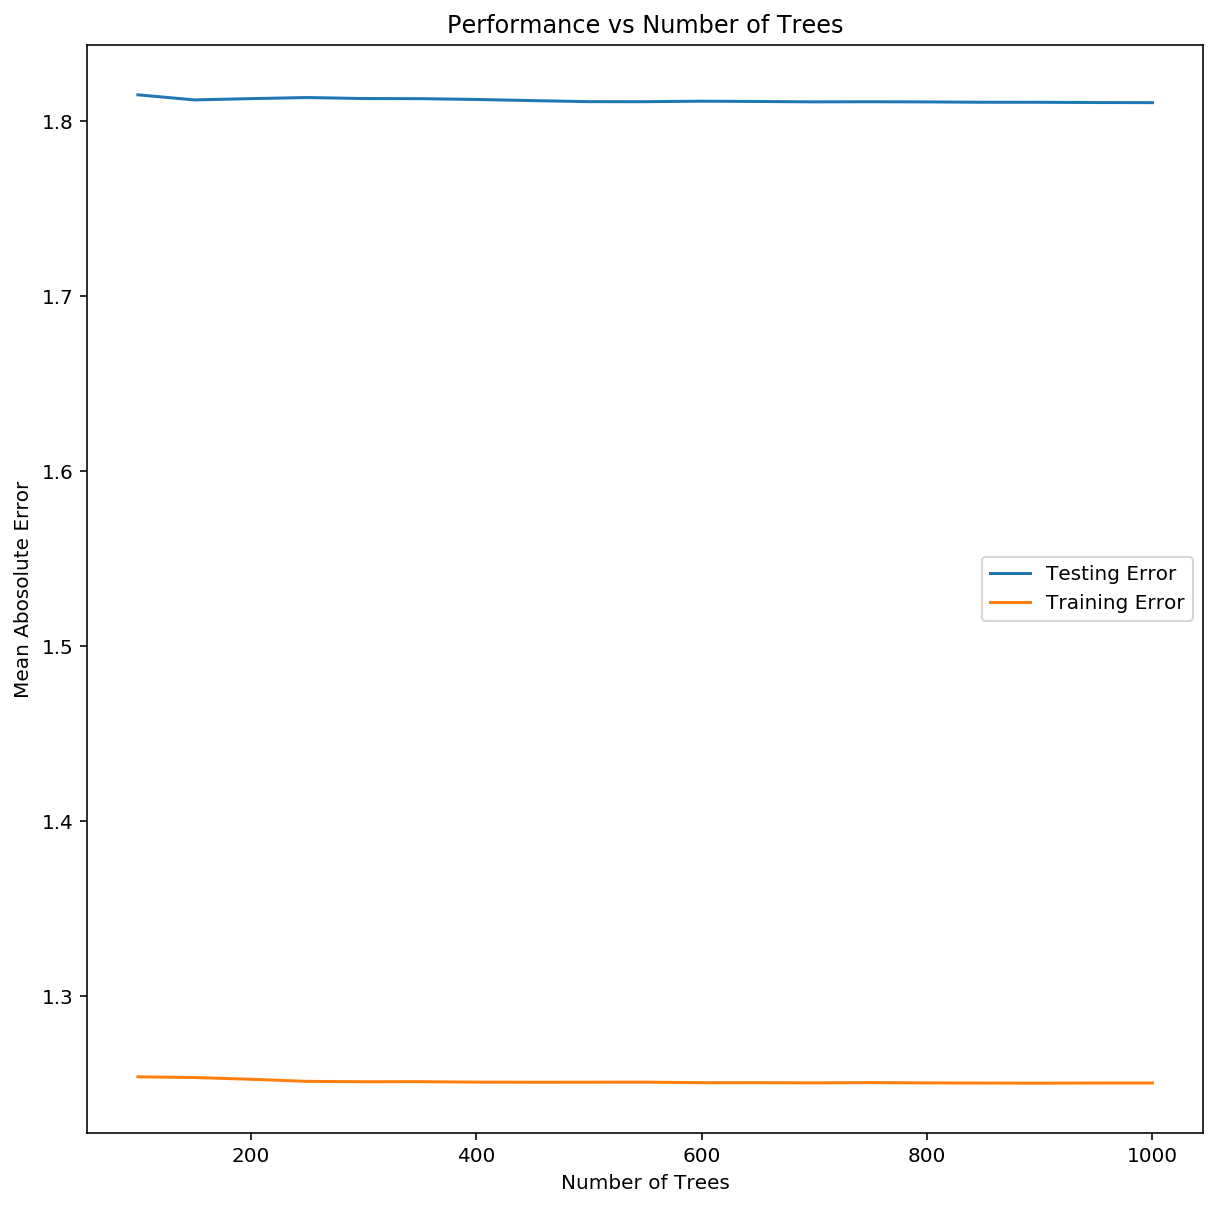

In [57]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(10, 10)
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [58]:
results.sort_values('mean_test_score', ascending = False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
18,7.679014,0.044551,0.371354,0.002767,1000,{'n_estimators': 1000},-1.846627,-1.812973,-1.747585,-1.835108,-1.810573,0.038324,1,-1.242544,-1.252117,-1.263860,-1.242662,-1.250296,0.008742
17,9.048470,0.019320,0.490646,0.002597,950,{'n_estimators': 950},-1.846949,-1.812895,-1.747238,-1.835479,-1.810641,0.038601,2,-1.242509,-1.252100,-1.263835,-1.242737,-1.250295,0.008722
16,8.530826,0.026199,0.479232,0.003707,900,{'n_estimators': 900},-1.847215,-1.813273,-1.747382,-1.835241,-1.810778,0.038572,3,-1.242151,-1.251918,-1.263888,-1.242791,-1.250187,0.008803
15,7.822361,0.047832,0.438403,0.002680,850,{'n_estimators': 850},-1.847312,-1.813681,-1.747062,-1.835132,-1.810797,0.038717,4,-1.242370,-1.252032,-1.263710,-1.242969,-1.250270,0.008652
14,7.370187,0.034060,0.429273,0.002297,800,{'n_estimators': 800},-1.847215,-1.813852,-1.747298,-1.835607,-1.810993,0.038675,5,-1.242424,-1.252016,-1.264093,-1.242874,-1.250352,0.008808
12,6.691921,0.013779,0.362573,0.001539,700,{'n_estimators': 700},-1.847845,-1.813290,-1.747094,-1.835837,-1.811017,0.038935,6,-1.242559,-1.252151,-1.264036,-1.242738,-1.250371,0.008792
13,6.896801,0.031155,0.397435,0.001227,750,{'n_estimators': 750},-1.847873,-1.813804,-1.747123,-1.835534,-1.811084,0.038890,7,-1.242639,-1.252159,-1.264219,-1.243028,-1.250511,0.008783
9,5.382155,0.032817,0.308232,0.015622,550,{'n_estimators': 550},-1.848313,-1.813039,-1.747040,-1.836057,-1.811112,0.039100,8,-1.242523,-1.252693,-1.264361,-1.243593,-1.250793,0.008774
8,4.754609,0.017700,0.264694,0.004916,500,{'n_estimators': 500},-1.847877,-1.812931,-1.747615,-1.836118,-1.811135,0.038769,9,-1.242528,-1.252630,-1.264331,-1.243506,-1.250749,0.008776
11,6.275497,0.044231,0.360221,0.008890,650,{'n_estimators': 650},-1.848054,-1.813288,-1.747402,-1.836203,-1.811237,0.038916,10,-1.242737,-1.252326,-1.263861,-1.242976,-1.250475,0.008642


# Evaluate Test Set

## Align test set with the training set

In [58]:
test = pd.read_csv("test.csv")

In [59]:
test.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole
3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family
4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield


1. Add New Features

In [60]:
test["is_red"] = (test['description']
                  .str
                  .contains(r'red|RED|Red',
                            regex=True)
                  .astype('uint8'))

test["is_white"] = (test['description']
                    .str
                    .contains(r'white|WHITE|White',
                              regex=True)
                    .astype('uint8'))

test["is_rose"] = (test['description']
                   .str
                   .contains(r'rose|ROSE|Rose|rosé|Rosé|ROSÉ',
                             regex=True)
                   .astype('uint8'))

test["is_sparkling"] = (test['description']
                        .str
                        .contains(r'sparkling|SPARKLING|Sparkling',
                                  regex=True)
                        .astype('uint8'))

test["is_dry"] = (test['description']
                  .str
                  .contains(r'dry|DRY|Dry',
                            regex=True)
                  .astype('uint8'))

test["is_sweet"] = (test['description']
                    .str
                    .contains(r'sweet|SWEETS|Sweet',
                              regex=True)
                    .astype('uint8'))

test["title_numlist"] = (test
                         .title
                         .str
                         .findall(r'\b\d+\b'))

test["year"] = (test
                .title_numlist
                .apply(find_production_year))

test["is_blend"] = (test
                    .variety
                    .apply(find_if_blend))

2. Drop Unused Features & Seperate Target and Features

In [61]:
test_target = test["points"]
test_features = test.drop(columns="points")

In [62]:
test_drop_column_list = []

for column in test_features.columns:
    if column not in X_train.columns:
        test_drop_column_list.append(column)

In [63]:
test_drop_column_list

['description',
 'designation',
 'region_2',
 'taster_twitter_handle',
 'title',
 'winery',
 'title_numlist']

In [64]:
test_features.drop(columns=test_drop_column_list,
                   inplace=True)

In [65]:
test_categorical_cols = list(test_features.select_dtypes(include="object").columns)
test_numeric_cols = list(test_features.select_dtypes(exclude="object").columns)

3. Impute Taster_name with Unknown

In [66]:
test_features=test_features.fillna({"taster_name":"Unknown"})

4. Encode Categorical Variables

In [67]:
#ordinal_encoder.fit(test_features)
test_features_ord_encoded = ordinal_encoder.transform(test_features)

In [68]:
test_features_ord_encoded

,country,price,province,region_1,taster_name,variety,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,year,is_blend
0,7.0,30.0,40.0,315.0,8.0,42.0,1,0,0,0,0,0,2012.0,0
1,5.0,22.0,32.0,191.0,3.0,11.0,1,0,0,0,0,0,2014.0,0
2,7.0,NaN,10.0,196.0,10.0,10.0,1,0,0,0,0,0,2009.0,0
3,1.0,50.0,9.0,50.0,12.0,6.0,1,0,1,0,0,0,2012.0,0
4,1.0,38.0,9.0,50.0,12.0,8.0,0,0,0,0,0,0,2013.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9.0,13.0,59.0,NaN,13.0,24.0,0,0,0,0,1,0,2016.0,0
996,5.0,18.0,58.0,268.0,5.0,11.0,0,0,1,0,0,0,2010.0,0
997,1.0,65.0,15.0,47.0,11.0,6.0,0,0,0,0,0,0,2014.0,0
998,3.0,60.0,49.0,NaN,3.0,51.0,1,0,0,0,1,0,2008.0,0


In [69]:
test_features

,country,price,province,region_1,taster_name,variety,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,year,is_blend
0,Italy,30.0,Northeastern Italy,Alto Adige,Kerin O’Keefe,Sauvignon,1,0,0,0,0,0,2012.0,0
1,France,22.0,Loire Valley,Sancerre,Roger Voss,Rosé,1,0,0,0,0,0,2014.0,0
2,Italy,NaN,Tuscany,Chianti Classico,Unknown,Sangiovese,1,0,0,0,0,0,2009.0,0
3,US,50.0,California,Russian River Valley,Virginie Boone,Pinot Noir,1,0,1,0,0,0,2012.0,0
4,US,38.0,California,Russian River Valley,Virginie Boone,Chardonnay,0,0,0,0,0,0,2013.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Germany,13.0,Rheinhessen,NaN,Anna Lee C. Iijima,Riesling,0,0,0,0,1,0,2016.0,0
996,France,18.0,Rhône Valley,Luberon,Joe Czerwinski,Rosé,0,0,1,0,0,0,2010.0,0
997,US,65.0,Oregon,Dundee Hills,Paul Gregutt,Pinot Noir,0,0,0,0,0,0,2014.0,0
998,Portugal,60.0,Port,NaN,Roger Voss,Port,1,0,0,0,1,0,2008.0,0


In [70]:
test_features_ord_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       1000 non-null   float64
 1   price         920 non-null    float64
 2   province      1000 non-null   float64
 3   region_1      831 non-null    float64
 4   taster_name   1000 non-null   float64
 5   variety       1000 non-null   float64
 6   is_red        1000 non-null   uint8  
 7   is_white      1000 non-null   uint8  
 8   is_rose       1000 non-null   uint8  
 9   is_sparkling  1000 non-null   uint8  
 10  is_dry        1000 non-null   uint8  
 11  is_sweet      1000 non-null   uint8  
 12  year          965 non-null    float64
 13  is_blend      1000 non-null   int64  
dtypes: float64(7), int64(1), uint8(6)
memory usage: 68.5 KB


5. Impute Test Dataset

In [71]:
test_features_ord_encoded = test_features_ord_encoded.fillna({"price": MEDIAN_PRICE,
                                                              "year": MEDIAN_YEAR})

imputed_test_features = most_frequent_imputer.transform(
    test_features_ord_encoded)

test_features_ready = pd.DataFrame(imputed_test_features,
                                   columns=test_features.columns)

In [68]:
#test_features.dropna(how="any")

In [91]:
#test_features = test_features.dropna(how="any")

In [72]:
test_features_ready

,country,price,province,region_1,taster_name,variety,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,year,is_blend
0,7.0,30.0,40.0,315.0,8.0,42.0,1.0,0.0,0.0,0.0,0.0,0.0,2012.0,0.0
1,5.0,22.0,32.0,191.0,3.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,2014.0,0.0
2,7.0,25.0,10.0,196.0,10.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,2009.0,0.0
3,1.0,50.0,9.0,50.0,12.0,6.0,1.0,0.0,1.0,0.0,0.0,0.0,2012.0,0.0
4,1.0,38.0,9.0,50.0,12.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9.0,13.0,59.0,55.0,13.0,24.0,0.0,0.0,0.0,0.0,1.0,0.0,2016.0,0.0
996,5.0,18.0,58.0,268.0,5.0,11.0,0.0,0.0,1.0,0.0,0.0,0.0,2010.0,0.0
997,1.0,65.0,15.0,47.0,11.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,0.0
998,3.0,60.0,49.0,55.0,3.0,51.0,1.0,0.0,0.0,0.0,1.0,0.0,2008.0,0.0


In [73]:
test_features_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       1000 non-null   float64
 1   price         1000 non-null   float64
 2   province      1000 non-null   float64
 3   region_1      1000 non-null   float64
 4   taster_name   1000 non-null   float64
 5   variety       1000 non-null   float64
 6   is_red        1000 non-null   float64
 7   is_white      1000 non-null   float64
 8   is_rose       1000 non-null   float64
 9   is_sparkling  1000 non-null   float64
 10  is_dry        1000 non-null   float64
 11  is_sweet      1000 non-null   float64
 12  year          1000 non-null   float64
 13  is_blend      1000 non-null   float64
dtypes: float64(14)
memory usage: 109.5 KB


In [74]:
test_features_ready.head()

,country,price,province,region_1,taster_name,variety,is_red,is_white,is_rose,is_sparkling,is_dry,is_sweet,year,is_blend
0,7.0,30.0,40.0,315.0,8.0,42.0,1.0,0.0,0.0,0.0,0.0,0.0,2012.0,0.0
1,5.0,22.0,32.0,191.0,3.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,2014.0,0.0
2,7.0,25.0,10.0,196.0,10.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,2009.0,0.0
3,1.0,50.0,9.0,50.0,12.0,6.0,1.0,0.0,1.0,0.0,0.0,0.0,2012.0,0.0
4,1.0,38.0,9.0,50.0,12.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0


In [75]:
test_target.head()

0    90
1    87
2    86
3    92
4    93
Name: points, dtype: int64

# Part to check if Ordinal encoding works for unkown values

In [ ]:
#test.tail()

In [72]:
#add_to_test = {'country': ['Mauritus', 'Nijer', 'Nigeria', 'Madagascar', 'US'], # -1 -1 -1 -1 _
#               'points': [83, 70, 55, 98, 91.5], 
#               'price': [42, 52, 36, 24, 70],
#               "province": ["California", "Edinburgh", "ABC", "DEF", 'Levante'], # _ -1 -1 -1 _
#               "region_1": ["Red Mountain","XYZ", "Toscana", "TUW", "Sta. Rita Hills"], 
#               "taster_name": ["Ceren Iyim", "Jonh Doe", "Ali Men", "Mary Jane", "Unknown"], # -1 -1 -1 -1 _
#               "variety": ['Bordeaux-style White Blend', "A", "B", "c", "D"]} #_ -1 -1 -1 -1 
#additional_test = pd.DataFrame(add_to_test, 
#                               columns=["country", 
#                                        'points', 
#                                        'price', 
#                                        "province", 
#                                        "region_1", 
#                                        "taster_name", 
#                                        "variety"])

In [73]:
#additional_test

,country,points,price,province,region_1,taster_name,variety
0,Mauritus,83.0,42,California,Red Mountain,Ceren Iyim,Bordeaux-style White Blend
1,Nijer,70.0,52,Edinburgh,XYZ,Jonh Doe,A
2,Nigeria,55.0,36,ABC,Toscana,Ali Men,B
3,Madagascar,98.0,24,DEF,TUW,Mary Jane,c
4,US,91.5,70,Levante,Sta. Rita Hills,Unknown,D


In [74]:
#test = pd.concat([test, additional_test])

In [76]:
#test.tail(10)

,country,points,price,province,region_1,taster_name,variety
993,US,86.0,15.0,Washington,Columbia Valley (WA),Sean P. Sullivan,Cabernet Sauvignon
994,US,87.0,32.0,California,Yolo County,Jim Gordon,Sparkling Blend
996,France,87.0,18.0,Rhône Valley,Luberon,Joe Czerwinski,Rosé
997,US,93.0,65.0,Oregon,Dundee Hills,Paul Gregutt,Pinot Noir
999,France,91.0,25.0,Loire Valley,Pouilly-Fumé,Roger Voss,Sauvignon Blanc
0,Mauritus,83.0,42.0,California,Red Mountain,Ceren Iyim,Bordeaux-style White Blend
1,Nijer,70.0,52.0,Edinburgh,XYZ,Jonh Doe,A
2,Nigeria,55.0,36.0,ABC,Toscana,Ali Men,B
3,Madagascar,98.0,24.0,DEF,TUW,Mary Jane,c
4,US,91.5,70.0,Levante,Sta. Rita Hills,Unknown,D


In [46]:
#test_target = test["points"]
#test_features = test.drop(columns="points")

In [56]:
#test_target = np.array(test_target).reshape((-1, ))

In [47]:
#test_features = ordinal_encoder.transform(test_features)

In [48]:
#test_features.tail(10)

,country,price,province,region_1,taster_name,variety
987,1,48.0,2.0,123.0,8,15.0
989,4,8.0,5.0,6.0,6,19.0
990,4,9.0,5.0,6.0,6,16.0
991,1,15.0,2.0,64.0,8,126.0
992,3,9.0,26.0,81.0,7,180.0
993,1,15.0,1.0,8.0,1,4.0
994,1,32.0,2.0,-1.0,9,41.0
996,3,18.0,37.0,338.0,3,19.0
997,1,65.0,12.0,133.0,4,15.0
999,3,25.0,57.0,249.0,7,9.0


In [81]:
# to check if ordinal encoding worked correctly
#test_features.drop(test_features.tail(5).index,inplace=True) # drop last n rows

In [49]:
#test_features.head()

,country,price,province,region_1,taster_name,variety
0,5,30.0,25.0,41.0,12,36.0
1,3,22.0,57.0,95.0,7,19.0
3,1,50.0,2.0,13.0,11,15.0
4,1,38.0,2.0,13.0,11,16.0
5,1,14.0,2.0,219.0,8,16.0


In [76]:
# Default model
default_model = RandomForestRegressor(random_state = 42)

# Select the best model
final_model = random_cv.best_estimator_

final_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [77]:
%%timeit #-n 1 -r 5
default_model.fit(X, y)

2.3 s ± 7.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
%%timeit #-n 1 -r 5
final_model.fit(X, y)

1.8 s ± 48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
default_predictions = default_model.predict(test_features_ready)
final_predictions = final_model.predict(test_features_ready)

print('Default model performance on the test set: MAE = %0.4f.' % mean_absolute_error(test_target, default_predictions))
print('Final model performance on the test set:   MAE = %0.4f.' % mean_absolute_error(test_target, final_predictions))

Default model performance on the test set: MAE = 1.7945.
Final model performance on the test set:   MAE = 1.7564.


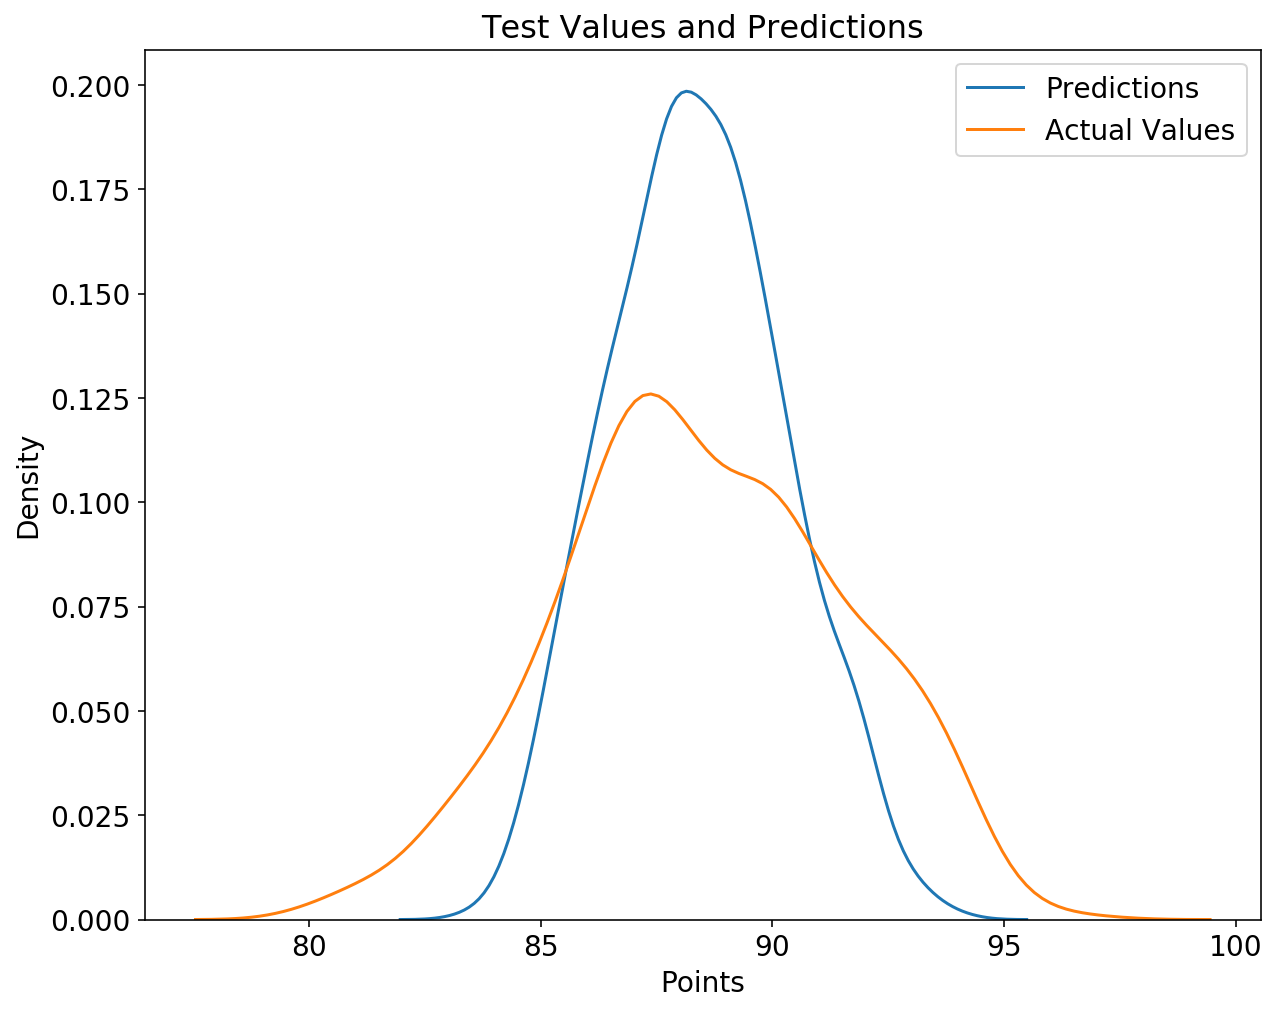

In [80]:
figsize(10, 20)
plt.rcParams['font.size'] = 14

# Density plot of the final predictions and the test values
sns.kdeplot(final_predictions, label = 'Predictions')
sns.kdeplot(test_target, label = 'Actual Values')

# Label the plot
plt.xlabel('Points', size=14); 
plt.ylabel('Density', size=14);
plt.title('Test Values and Predictions', size=16);

**Distribution of Actuals and Predicted Values**

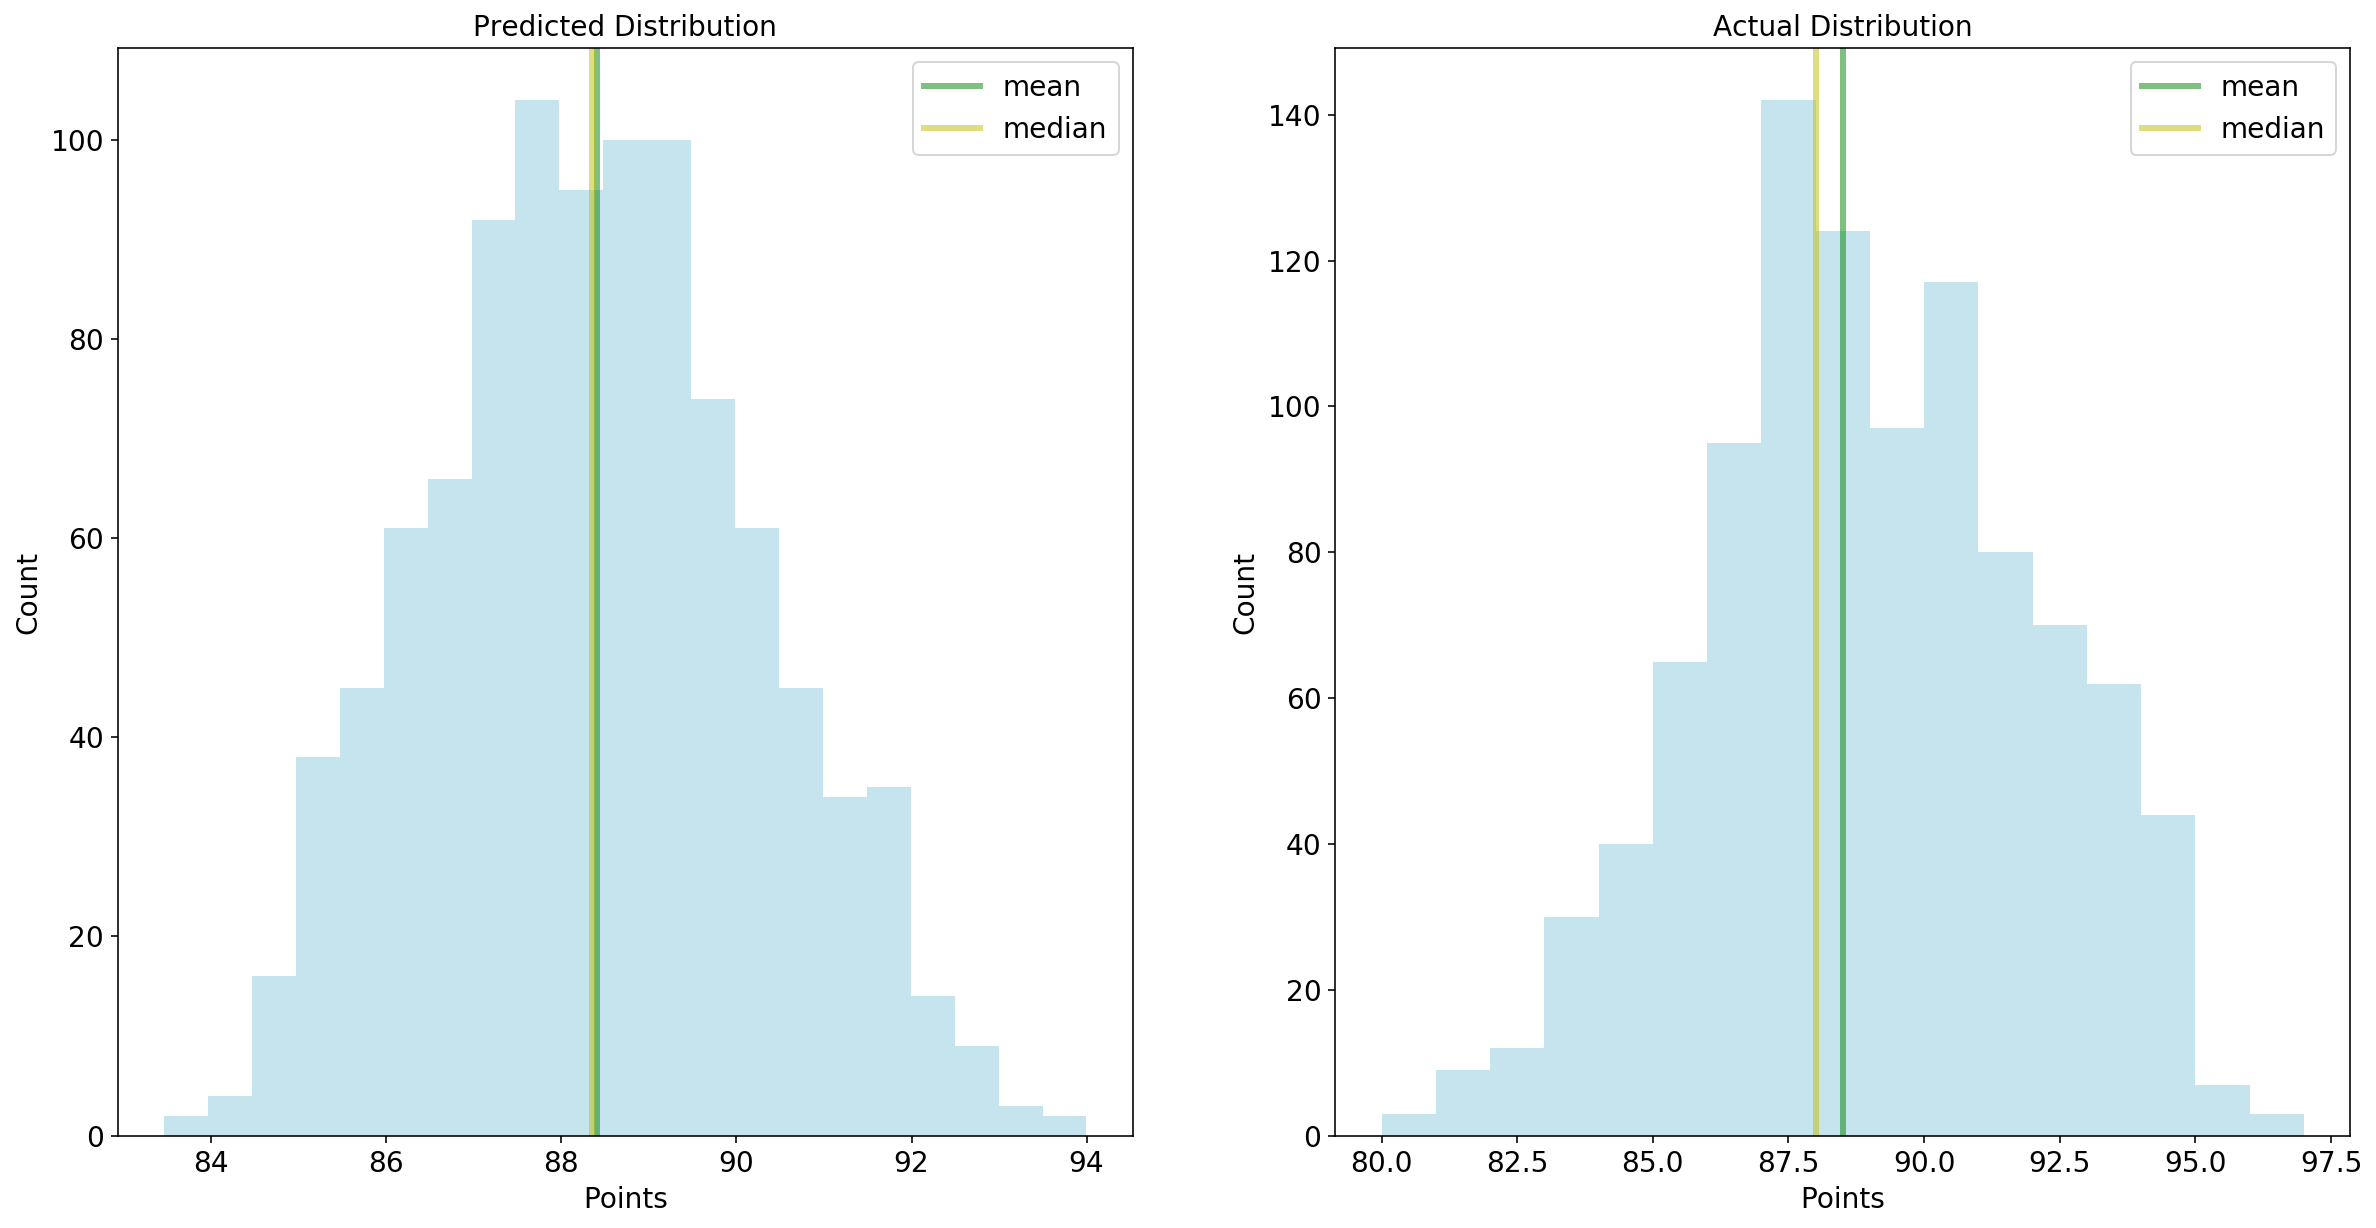

In [81]:
#looking predicted vs actuals as histograms
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot points distribution for top country
plt.subplot(1,2,1)
sns.distplot(final_predictions, kde=False, color="#72bcd4")
plt.axvline(x=final_predictions.mean(),
                linewidth=3,
                color='g',
                label="mean",
                alpha=0.5)
plt.axvline(x=np.median(final_predictions),
            linewidth=3,
            color='y',
            label="median",
            alpha=0.5)

# set title, legends and labels
plt.xlabel("Points", size=14)
plt.ylabel("Count", size=14)
plt.title("Predicted Distribution", size=14)
plt.legend(["mean", "median"])

plt.subplot(1,2,2)
sns.distplot(test_target, kde=False, color="#72bcd4")
plt.axvline(x=test_target.mean(),
            linewidth=3,
            color='g',
            label="mean",
            alpha=0.5)
plt.axvline(x=np.median(test_target),
            linewidth=3,
            color='y',
            label="median",
            alpha=0.5)

# set title, legends and labels
plt.xlabel("Points", size=14)
plt.ylabel("Count", size=14)
plt.title("Actual Distribution", size=14)
plt.legend(["mean", "median"])

**Feature Importances**

In [82]:
# Extract the feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': test_features_ready.columns,
                                    'importance': final_model.feature_importances_})
featured_importances = feature_importances.sort_values(by="importance", ascending=False)

Text(0.5, 1.0, 'Feature Importances')

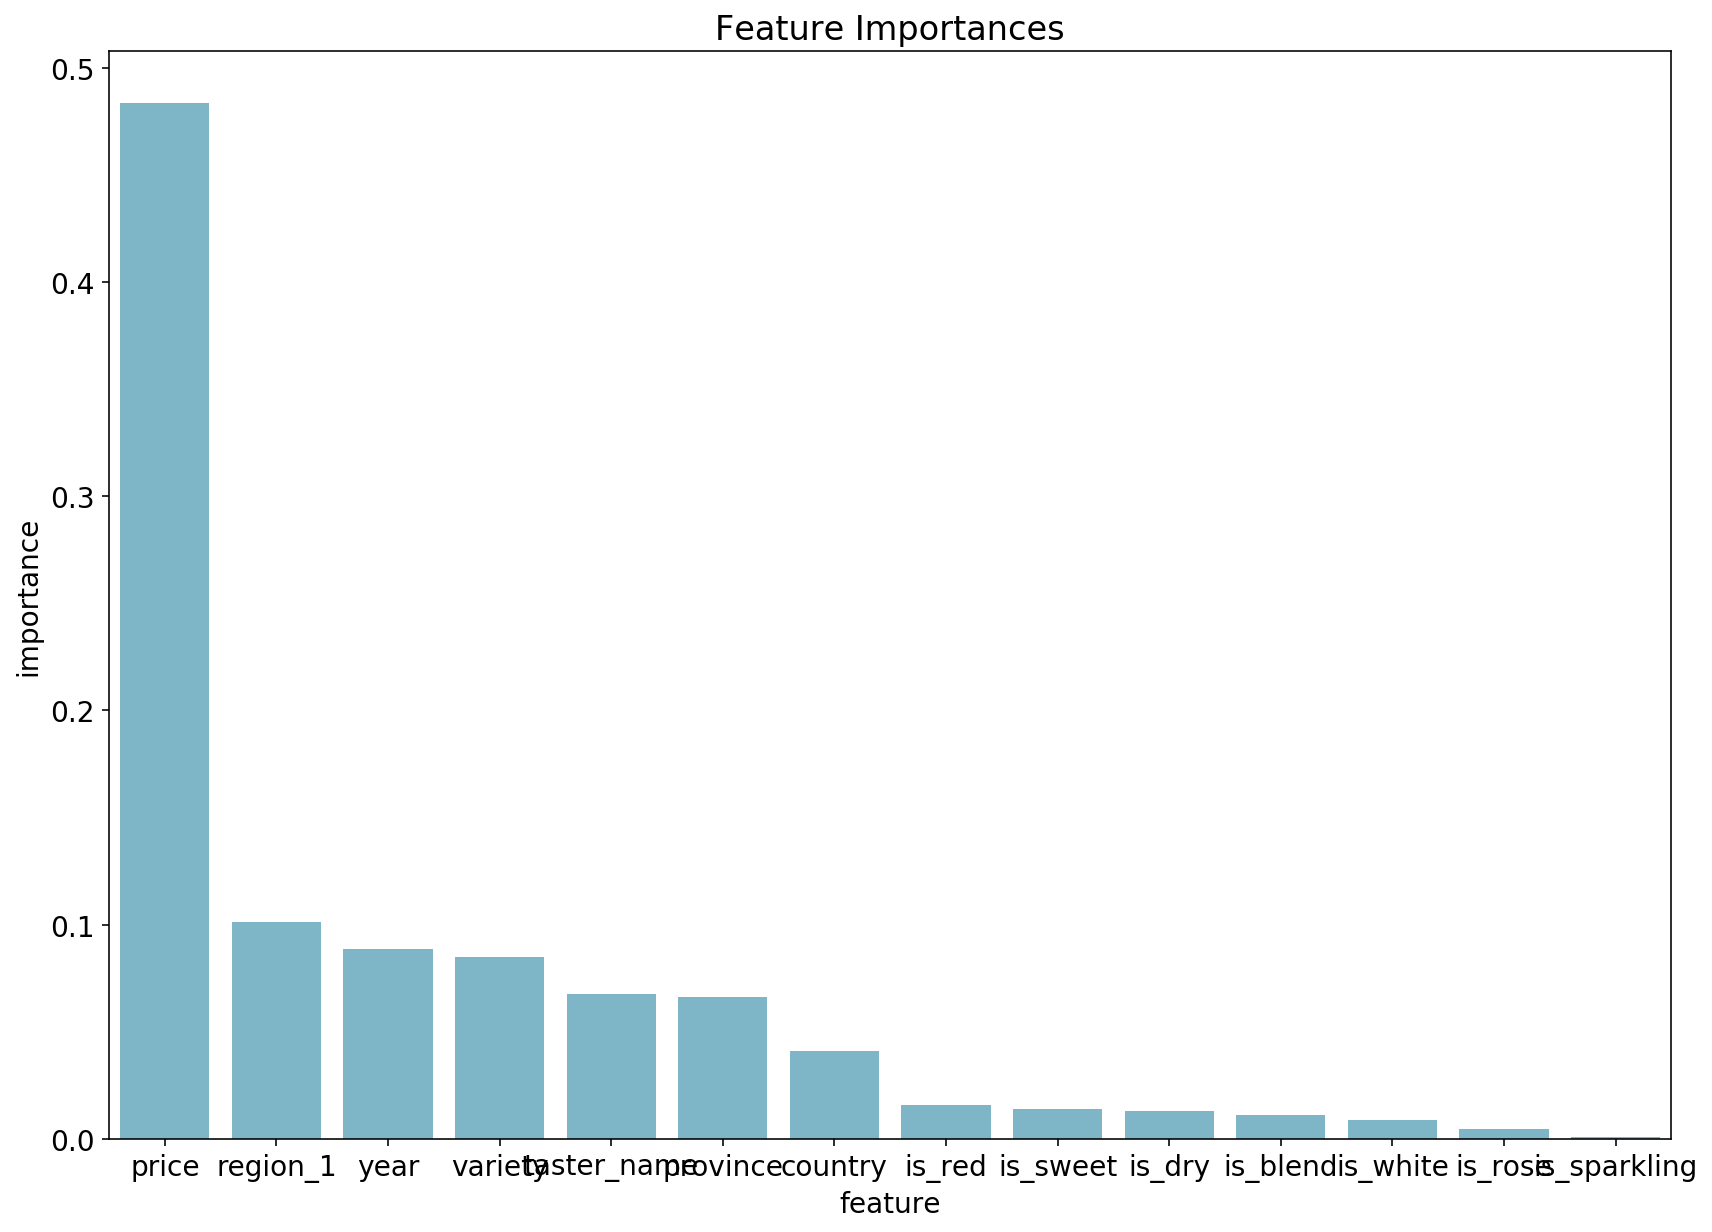

In [83]:
figsize(14, 10)

sns.barplot(x='feature', y='importance',
            data=featured_importances,
            color="#72bcd4")
plt.title("Feature Importances")
#"#add8e6")

# Hyperparamater Tuning S1-GB
**Best Gradient Boosting Parameters**
* loss='huber'
* n_estimators=500
* max_depth=3
* min_samples_leaf=2
* min_samples_split=4
* max_features='auto' 
MAE dropped from 1.86 to 1.83

In [29]:
# Loss function to be optimized
#loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
#n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
#max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
#min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
#min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
#max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
#gb_hyperparameter_grid = {'loss': loss,
#                          'n_estimators': n_estimators,
#                          'max_depth': max_depth,
#                          'min_samples_leaf': min_samples_leaf,
#                          'min_samples_split': min_samples_split,
#                          'max_features': max_features}

In [31]:
# Create the model to use for hyperparameter tuning
#model = GradientBoostingRegressor(random_state=42)

# Set up the random search with 4-fold cross validation
#random_cv = RandomizedSearchCV(estimator=model,
#                               param_distributions=gb_hyperparameter_grid,
#                               cv=4, n_iter=20,
#                               scoring='neg_mean_absolute_error',
#                               n_jobs=-1, verbose=1,
#                               return_train_score=True,
#                               random_state=42)
# Fit on the training data
#random_cv.fit(features_le, target)

In [32]:
#random_cv.best_estimator_

**Best Gradient Boosting Parameters**
* loss='huber'
* n_estimators=500
* max_depth=3
* min_samples_leaf=2
* min_samples_split=4
* max_features='auto'


In [33]:
#rcv_gb = GradientBoostingRegressor(loss='huber',
#                                   n_estimators=500,
#                                   max_depth=3,
#                                   min_samples_leaf=2,
#                                   min_samples_split=4,
#                                   max_features='auto',
#                                   random_state=42)
#rcv_gb_mae = fit_evaluate_model(
#    rcv_gb, X_train, y_train, X_valid, y_valid)
#
#print("MAE of Extra Gradient Boosting after random search", rcv_gb_mae)

In [34]:
# Create a range of trees to evaluate
#gb_trees_grid = {'n_estimators': [
#    100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

#gb_grid_search_model = GradientBoostingRegressor(loss='huber',
#                                                 max_depth=3,
#                                                 min_samples_leaf=2,
#                                                 min_samples_split=4,
#                                                 max_features='auto',
#                                                 random_state=42)

# Grid Search Object using the trees range and the random forest model
#gb_grid_search = GridSearchCV(estimator=gb_grid_search_model, param_grid=gb_trees_grid, cv=4,
#                              scoring='neg_mean_absolute_error', verbose=1,
#                              n_jobs=-1, return_train_score=True)

# Fit the grid search
#gb_grid_search.fit(features_le, target)

In [35]:
# Get the results into a dataframe
#gb_results = pd.DataFrame(gb_grid_search.cv_results_)

# Plot the training and testing error vs number of trees
#figsize(8, 8)
#plt.plot(results['param_n_estimators'], -1 * gb_results['mean_test_score'], label = 'Testing Error')
#plt.plot(results['param_n_estimators'], -1 * gb_results['mean_train_score'], label = 'Training Error')
#plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
#plt.title('Performance vs Number of Trees');

In [36]:
#gb_results.sort_values('mean_test_score', ascending = False).head(5)

In [37]:
#SCORERS.keys()

In [2]:
a= {'name': ['Pam adaw', np.nan, 'Stanley-ade', np.nan, 'Bob_Vance Blend'],
             'nationality': ['USA', 'USA', np.nan, "USA", 'UK'],
             'age': [42, 42, 42, np.nan, np.nan]}

b = pd.DataFrame(a, columns=['name', 'nationality', 'age'])

In [3]:
b

,name,nationality,age
0,Pam adaw,USA,42.0
1,NaN,USA,42.0
2,Stanley-ade,NaN,42.0
3,NaN,USA,NaN
4,Bob_Vance Blend,UK,NaN


In [4]:
c = b.dropna(subset=["age"], how="any").reset_index(drop=True)

In [5]:
c

,name,nationality,age
0,Pam adaw,USA,42.0
1,NaN,USA,42.0
2,Stanley-ade,NaN,42.0


In [6]:
c.index

RangeIndex(start=0, stop=3, step=1)

In [ ]:
imputer = SimpleImputer()

In [14]:
def find_if_blend2(variety):
    if variety.isna():
        pass
    
    else:
        if (variety.find("-") != -1) | (variety.find("Blend") != -1):
            if variety == "Xarel-lo":
                return 0
            else:
                return 1
        else:
            return 0

In [15]:
b["new_col"] = b.name.apply(find_if_blend2)

AttributeError: 'str' object has no attribute 'isna'

In [10]:
b

,name,nationality,age,new_col
0,Pam adaw,USA,42,0
1,NaN,USA,42,0
2,Stanley-ade,USA,42,0
3,NaN,USA,42,0
4,Bob_Vance Blend,UK,70,0
